## Baseline modelling

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/processed/credit_processed.csv')

In [3]:
X = df.drop(columns = ['Target'])
y = df['Target']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

__Stratified the data so that X_train and X_val have target classes in ratio of actual dataset__

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
lr.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [7]:
from sklearn.metrics import roc_auc_score, classification_report
y_val_prob = lr.predict_proba(X_val_scaled)[:,1]

roc_auc = roc_auc_score(y_val, y_val_prob)
print(roc_auc)

0.709246838167149


In [8]:
print(classification_report(y_val, lr.predict(X_val_scaled)))

              precision    recall  f1-score   support

           0       0.86      0.70      0.78      4673
           1       0.37      0.61      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.75      0.68      0.71      6000



In [9]:
coef_df = pd.DataFrame({'features':X.columns, 'coefficients':lr.coef_[0]}).sort_values(by = 'coefficients', key = abs, ascending = False)
coef_df.head(10)

,features,coefficients
5,pay_0,0.568226
11,bill_amt1,-0.279908
0,limit_bal,-0.189010
17,pay_amt1,-0.185663
18,pay_amt2,-0.162886
24,avg_payment_delay,0.133959
23,credit_utilization,-0.095908
2,education,-0.090475
12,bill_amt2,0.084753
4,age,0.079664


- __Person who delays the last month's payment, in the same proportion he is more likely to default__
- __Person whose last month's bill is more is less likely to default__
- __Person whose credit limit is more (is rich) is less likely to default__





## Gradient Boosting (Tree model)

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.05, max_depth = 3, random_state = 42)

In [11]:
gb.fit(X_train, y_train)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",200
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``,

In [12]:
y_val_proba_gb = gb.predict_proba(X_val)[:,1]
gb_auc_roc = roc_auc_score(y_val, y_val_proba_gb)
print("ROC-AUC score: {}".format(gb_auc_roc))

ROC-AUC score: 0.7824828162748017


In [13]:
fi = pd.DataFrame({'features':X.columns, 'importance':gb.feature_importances_}).sort_values(by='importance', ascending = False)
fi.head(10)

,features,importance
5,pay_0,0.570203
24,avg_payment_delay,0.171905
23,credit_utilization,0.033390
25,payment_to_bill_ratio,0.028994
11,bill_amt1,0.028878
19,pay_amt3,0.021103
6,pay_2,0.020685
0,limit_bal,0.018688
18,pay_amt2,0.015723
17,pay_amt1,0.012220


__pay_0, avg_payment_delay and credit utilization contribute majorly in Decision tree__

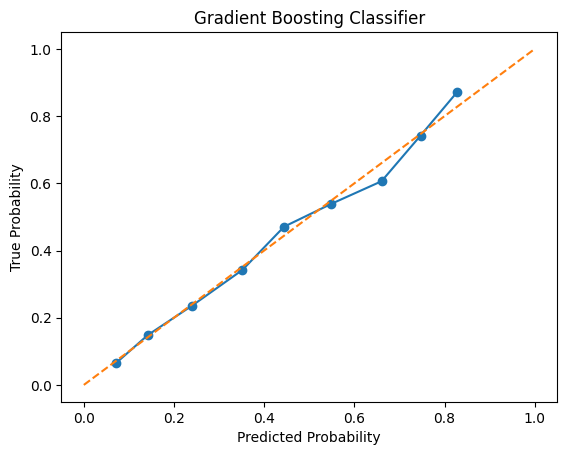

In [14]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_val, y_val_proba_gb, n_bins = 10)
plt.plot(prob_pred, prob_true, marker = 'o')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Gradient Boosting Classifier')
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
gb_cal = CalibratedClassifierCV(gb, method = 'isotonic', cv=5)
gb_cal.fit(X_train, y_train)
y_val_proba_cal = gb_cal.predict_proba(X_val)[:,1]

prob_true, prob_pred = calibration_curve(y_val, y_val_proba_cal, n_bins = 10)
plt.plot(prob_pred, prob_true, marker = 'o')
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Gradient Boosting Classifier')
plt.show()

In [ ]:
gb_cal_roc_auc = roc_auc_score(y_val, y_val_proba_cal)
print("roc-auc-score: {}".format(gb_cal_roc_auc))

In [ ]:
import joblib
joblib.dump(gb, "gb_model.pkl")
joblib.dump(gb_cal, "gb_calibrated_model.pkl")